In [73]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import random
from collections import defaultdict
from matplotlib import pyplot as plt
import math

%matplotlib inline
plt.style.use('ggplot')
font = {'size'   : 12}
plt.rc('font', **font)

In [91]:
def get_data(path):
    df = pd.read_csv(path)
    df = df.iloc[:,2:]
#     df = df[df['shares'] < 4000]
    return df

def get_log_shares(df):
    df['value'] = df['shares'].map(lambda x: math.log(x+1))
    return df

def get_feature_target(df, train_cols):
    X = df[train_cols]
    y = df['value']
    return X, y

def feature_scaling(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def log_to_shares(log):
    return np.array([math.exp(x) - 1 for x in log])

def model_eval(X_scaled, y, model):
    kf = KFold(n_splits=5, shuffle=True)
    rmse = []
    rsqr = []
    for train_idx, test_idx in kf.split(X_scaled):
        model.fit(X_scaled[train_idx], y.iloc[train_idx])
        y_pred_log = model.predict(X_scaled[test_idx])
        y_true_log = y.iloc[test_idx]
        y_pred = log_to_shares(y_pred_log)
        y_true = log_to_shares(y_true_log)
        rmse.append(mean_squared_error(y_true, y_pred,squared = False))
        rsqr.append(r2_score(y_true, y_pred))
    return rmse, rsqr

def model_output(train_cols):
    df = get_data('../data/train.csv')
    df = get_log_shares(df)
    X, y = get_feature_target(df, train_cols)
    X_scaled = feature_scaling(X)
    return df, X_scaled, y

def print_model_score(model, train_cols):
    df, X_scaled, y = model_output(train_cols)
    rmse, rsqr = model_eval(X_scaled, y, model)
    print("RMSE:", np.average(rmse))
    print("R^2:", np.var(rsqr))

In [40]:
train_cols = ['timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity']

### Regression on Entire training data

In [41]:
df, X_scaled, y = model_output(train_cols)

In [74]:
# baseline model
mean_shares = df['shares'].mean() 
shares_pred = np.ones(len(df))*mean_shares
print("RMSE: {}".format(mean_squared_error(df['shares'] , shares_pred, squared = False)))
print("R^2: {}".format(r2_score(df['shares'] , shares_pred)))

RMSE: 11785.079234359131
R^2: 0.0


In [76]:
# linear regression
model = LinearRegression()
print_model_score(model, train_cols)

RMSE: 11684.121360414716
R^2: 0.0017962079842813133


In [77]:
# RMF regression
model = RandomForestRegressor()
print_model_score(model, train_cols)

RMSE: 11184.623184899505
R^2: 4.3401006299655056e-06


### Regression on data excluding extreme popular articles

In [82]:
df, X_scaled, y = model_output(train_cols)

In [84]:
# baseline model
mean_shares = df['shares'].mean() 
shares_pred = np.ones(len(df))*mean_shares
print("RMSE: {}".format(mean_squared_error(df['shares'] , shares_pred, squared = False)))
print("R^2: {}".format(r2_score(df['shares'] , shares_pred)))

RMSE: 813.8554975120064
R^2: 0.0


In [85]:
# linear regression
model = LinearRegression()
print_model_score(model, train_cols)

RMSE: 798.9833580268872
R^2: 0.0020548034395024436


In [86]:
# RMF regression
model = RandomForestRegressor()
print_model_score(model, train_cols)

RMSE: 769.9798898310725
R^2: 4.575230940327546e-05


### EDA

In [164]:
df = get_data('../data/train.csv')

<AxesSubplot:>

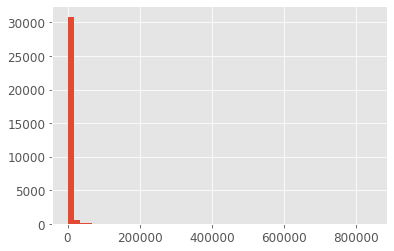

In [10]:
df['shares'].hist(bins=50)

In [22]:
df['value'] = df['shares'].map(lambda x: math.log(x+1))

<AxesSubplot:>

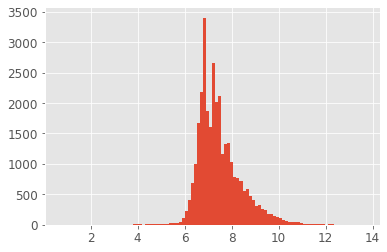

In [31]:
df['value'].hist(bins=100)

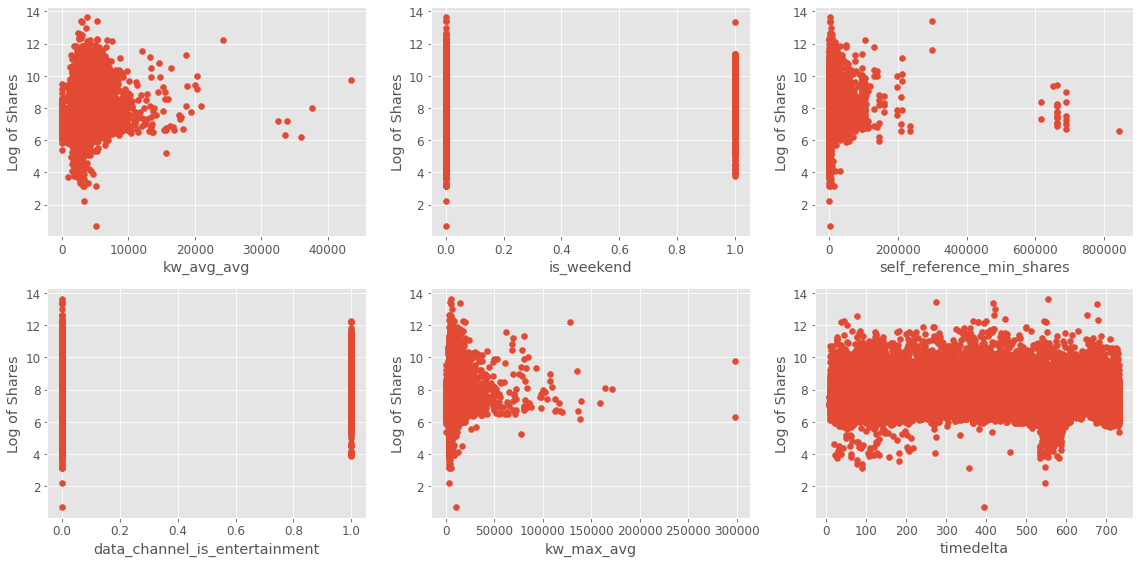

In [35]:
cols = ['kw_avg_avg', 'is_weekend', 'self_reference_min_shares','data_channel_is_entertainment', 'kw_max_avg', 'timedelta']

fig, axs = plt.subplots(2,3,figsize=(16,8))
for i, ax in enumerate(axs.flatten()):
    ax.scatter(df[cols[i]], df['value'])
    ax.set_xlabel(cols[i])
    ax.set_ylabel('Log of Shares')

fig.tight_layout()

In [36]:
df.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,value
0,127.0,9.0,423.0,0.541872,1.0,0.637993,15.0,3.0,2.0,1.0,...,0.5,-0.345000,-1.000,-0.125000,0.50,0.50,0.00,0.50,3300,8.101981
1,61.0,12.0,0.0,0.000000,0.0,0.000000,0.0,0.0,14.0,0.0,...,0.0,0.000000,0.000,0.000000,0.25,0.25,0.25,0.25,3400,8.131825
2,182.0,15.0,654.0,0.486656,1.0,0.704735,4.0,1.0,1.0,2.0,...,1.0,-0.372863,-1.000,-0.050000,0.30,0.20,0.20,0.20,2500,7.824446
3,218.0,8.0,403.0,0.574307,1.0,0.784404,10.0,0.0,1.0,0.0,...,1.0,-0.379365,-0.700,-0.155556,0.50,0.00,0.00,0.00,2100,7.650169
4,197.0,11.0,928.0,0.370000,1.0,0.466780,6.0,6.0,19.0,0.0,...,0.5,-0.112500,-0.125,-0.100000,0.00,0.00,0.50,0.00,1300,7.170888


<AxesSubplot:>

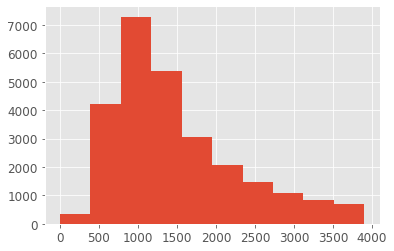

In [79]:
df[df['shares'] < 4000]['shares'].hist()

<AxesSubplot:>

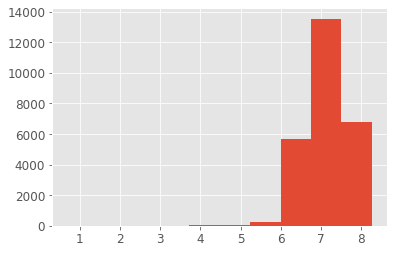

In [80]:
df[df['shares'] < 4000]['value'].hist()

In [194]:
data = pd.read_csv('../data/OnlineNewsPopularity.csv')

In [199]:
data = data.rename(columns = lambda x: x.strip())

In [200]:
def add_day_of_week(df):
    df_week = df.loc[:, ['weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday']]
    df_week['day_of_week'] = df_week.idxmax(axis=1)
    #df_week['day_of_week'] = df_week['day_of_week'].map(lambda x: x[11:])
    df_week['day_of_week'] = df_week['day_of_week'].map(lambda x: 1 if x =='weekday_is_monday' else x)
    df_week['day_of_week'] = df_week['day_of_week'].map(lambda x: 2 if x =='weekday_is_tuesday' else x)
    df_week['day_of_week'] = df_week['day_of_week'].map(lambda x: 3 if x =='weekday_is_wednesday' else x)
    df_week['day_of_week'] = df_week['day_of_week'].map(lambda x: 4 if x =='weekday_is_thursday' else x)
    df_week['day_of_week'] = df_week['day_of_week'].map(lambda x: 5 if x =='weekday_is_friday' else x)
    df_week['day_of_week'] = df_week['day_of_week'].map(lambda x: 6 if x =='weekday_is_saturday' else x)
    df_week['day_of_week'] = df_week['day_of_week'].map(lambda x: 7 if x =='weekday_is_sunday' else x)
    df = pd.concat([df, df_week['day_of_week']], axis=1)
    return df

In [201]:
data = add_day_of_week(data)

In [202]:
def add_topic(df):
    df_topic = df.loc[:, ['data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world']]
    df_topic['topic'] = df_topic.idxmax(axis=1)
    df_topic['topic'] = df_topic['topic'].map(lambda x: x[16:])
    df_topic['topic'] = df_topic['topic'].map(lambda x: 'business' if x=='bus' else x)
    df_topic['topic'] = df_topic['topic'].map(lambda x: 'socia media' if x=='socmed' else x)
    df = pd.concat([df, df_topic['topic']], axis=1)
    return df

In [203]:
data = add_topic(data)

In [220]:
df1=data.groupby(['day_of_week']).sum()['shares'].to_frame().reset_index()

In [231]:
df2=data.groupby(['topic']).sum()['shares'].to_frame().reset_index()

Text(0.5, 1.0, 'Topics Bar Graph of 39644 instances')

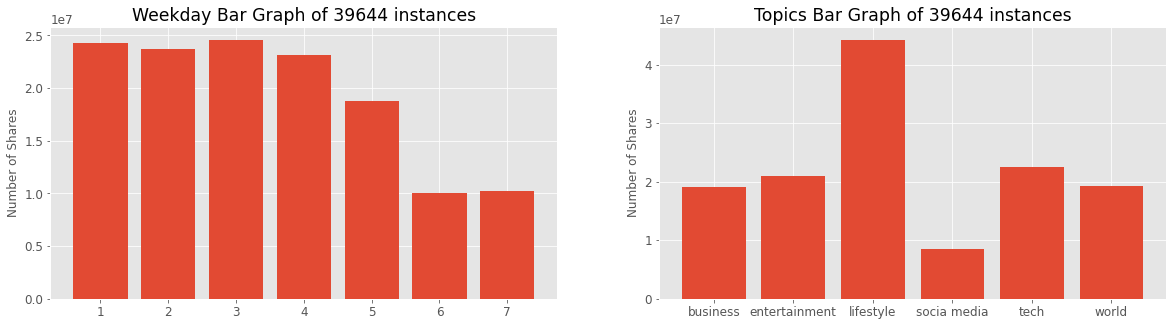

In [232]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].bar(df1.iloc[:,0], df1.iloc[:,1])
axs[1].bar(df2.iloc[:,0], df2.iloc[:,1])
axs[0].set_ylabel('Number of Shares', fontsize=12)
axs[1].set_ylabel('Number of Shares', fontsize=12)
axs[0].set_title("Weekday Bar Graph of 39644 instances")
axs[1].set_title("Topics Bar Graph of 39644 instances")